# Application: Assurances médicales

Pour cet exemple, nous utiliserons un ensemble de données simulées contenant des dépenses médicales pour des patients aux États-Unis.

## Les données

Le fichier `insurance.csv` comprend 1 338 exemples de bénéficiaires actuellement inscrits au régime d'assurance, avec des traits indiquant les caractéristiques du patient ainsi que le total des frais médicaux imputés au régime pour l'année civile. 

Les caractéristiques sont :
- age : Un nombre entier indiquant l'âge du bénéficiaire principal (à l'exclusion des personnes âgées de plus de 64 ans, car elles sont généralement couvertes par le gouvernement).
- sex : Le sexe du titulaire de la police : soit homme, soit femme.
- bmi : L'indice de masse corporelle (IMC), qui donne une idée de l'excès ou de l'insuffisance de poids d'une personne par rapport à sa taille.
- children : Un nombre entier indiquant le nombre d'enfants/personnes à charge couverts par le régime d'assurance.
- smoker : Une variable catégorielle oui ou non qui indique si l'assuré fume régulièrement du tabac.
- region : Le lieu de résidence du bénéficiaire aux États-Unis, divisé en quatre régions géographiques : nord-est, sud-est, sud-ouest ou nord-ouest.

Il est important de réfléchir à la manière dont ces variables peuvent être liées aux frais médicaux facturés. Par exemple, on pourrait s'attendre à ce que les personnes âgées et les fumeurs sont plus susceptibles d'avoir des dépenses médicales importantes. 

## Exploration et préparation des données
Nous utiliserons la fonction read.csv() pour charger les données à analyser. Nous pouvons utiliser sans risque stringsAsFactors = TRUE car il convient de convertir les trois variables nominales en facteurs :

In [33]:
insurance <- read.csv("insurance.csv", stringsAsFactors = TRUE)

La fonction str() confirme que les données sont formatées comme nous l'avions prévu :

In [77]:
str(insurance)

'data.frame':	1338 obs. of  10 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 25.7 33.4 27.7 29.8 25.8 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 1 1 1 ...
 $ region  : Factor w/ 4 levels "northeast","northwest",..: 4 3 3 2 2 3 3 2 1 2 ...
 $ expenses: num  16885 1726 4449 21984 3867 ...
 $ age2    : num  361 324 784 1089 1024 ...
 $ bmi30   : num  0 1 1 0 0 0 1 0 0 0 ...
 $ pred    : num  16390 3165 5816 5068 5601 ...


La variable dépendante de notre modèle est les dépenses, qui mesurent les frais médicaux que chaque personne a facturés au régime d'assurance pour l'année. Avant de construire un modèle de régression, il est souvent utile de vérifier la normalité. Bien que la régression linéaire ne nécessite pas strictement une variable dépendante normalement distribuée, le modèle s'adapte souvent mieux lorsque c'est le cas. Jetons un coup d'œil aux statistiques récapitulatives :

In [34]:
summary(insurance$expenses)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1122    4740    9382   13270   16640   63770 

Comme la valeur moyenne est supérieure à la médiane, cela implique que la distribution des dépenses d'assurance est ce qu'on appelle en anglais _right-skewed_. Nous pouvons le confirmer visuellement en utilisant un histogramme :

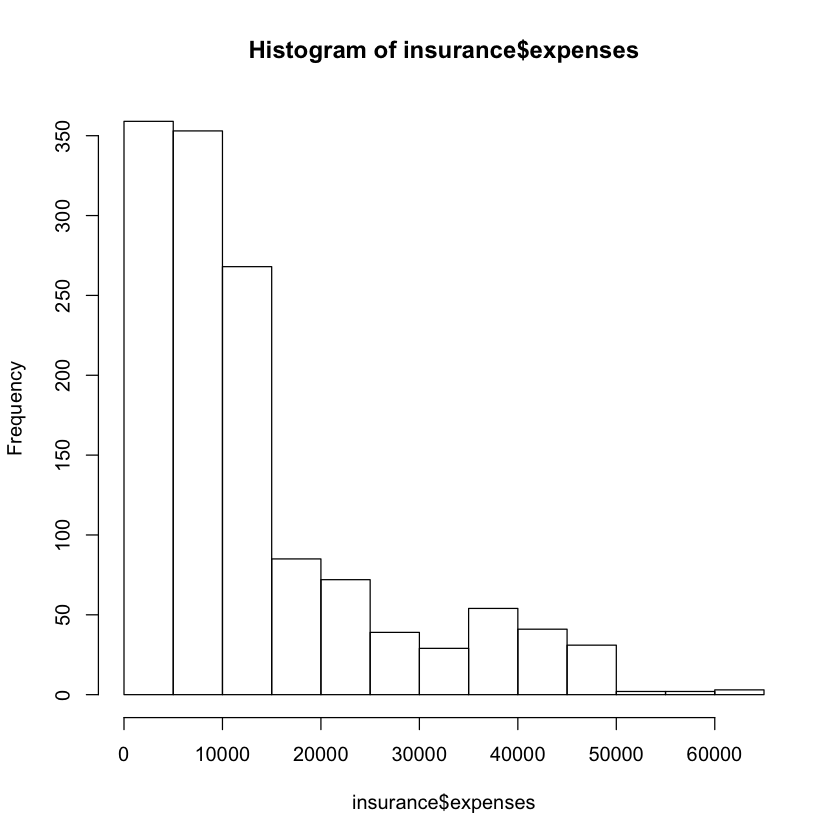

In [35]:
hist(insurance$expenses)

Comme prévu, la figure montre une distribution à angle droit. Elle montre également que la majorité des personnes figurant dans nos données ont des frais médicaux annuels compris entre zéro et 15 000 \\$, même si la queue de la distribution s'étend bien au-delà de ces pics. Bien que cette distribution ne soit pas idéale pour une régression linéaire, le fait de connaître cette faiblesse à l'avance peut nous aider à concevoir un modèle mieux adapté par la suite.

Avant d'aborder cette question, un autre problème se pose. Les modèles de régression exigent que chaque caractéristique soit numérique, or nous avons trois caractéristiques de type facteur dans notre cadre de données. Par exemple, la variable sexe est divisée en deux niveaux, masculin et féminin, tandis que fumeur a des catégories pour oui et non. D'après la sortie de summary(), nous savons que la région
a quatre niveaux, mais nous devons regarder de plus près pour voir comment ils sont distribués :

In [38]:
table(insurance$region)


northeast northwest southeast southwest 
      324       325       364       325 

Ici, nous voyons que les données ont été réparties de manière presque égale entre quatre régions géographiques. Nous verrons bientôt comment la fonction de régression linéaire de R traite ces variables de facteur.

## La relations entre les variables 

Avant d'ajuster un modèle de régression aux données, il peut être utile de déterminer comment les variables indépendantes sont liées à la variable dépendante et aux autres variables. 

Une matrice de corrélation fournit un aperçu rapide de ces relations. Étant donné un ensemble de variables, elle fournit une corrélation pour chaque relation par paire.

In [39]:
cor(insurance[c("age", "bmi", "children", "expenses")])

age       bmi        children   expenses  
age      1.0000000 0.10934101 0.04246900 0.29900819
bmi      0.1093410 1.00000000 0.01264471 0.19857626
children 0.0424690 0.01264471 1.00000000 0.06799823
expenses 0.2990082 0.19857626 0.06799823 1.00000000

In [40]:
mat_corr<-cor(insurance[c("age", "bmi", "children", "expenses")])

À l'intersection de chaque paire de lignes et de colonnes, la corrélation est indiquée pour les variables indiquées par cette ligne et cette colonne. La diagonale est toujours égale à 1,0000000 car il existe toujours une corrélation parfaite entre une variable et elle-même. Les valeurs situées au-dessus et au-dessous de la diagonale sont identiques puisque les corrélations sont symétriques. En d'autres termes, cor(x, y) est égal à cor(y, x).

In [45]:
library(ggcorrplot)

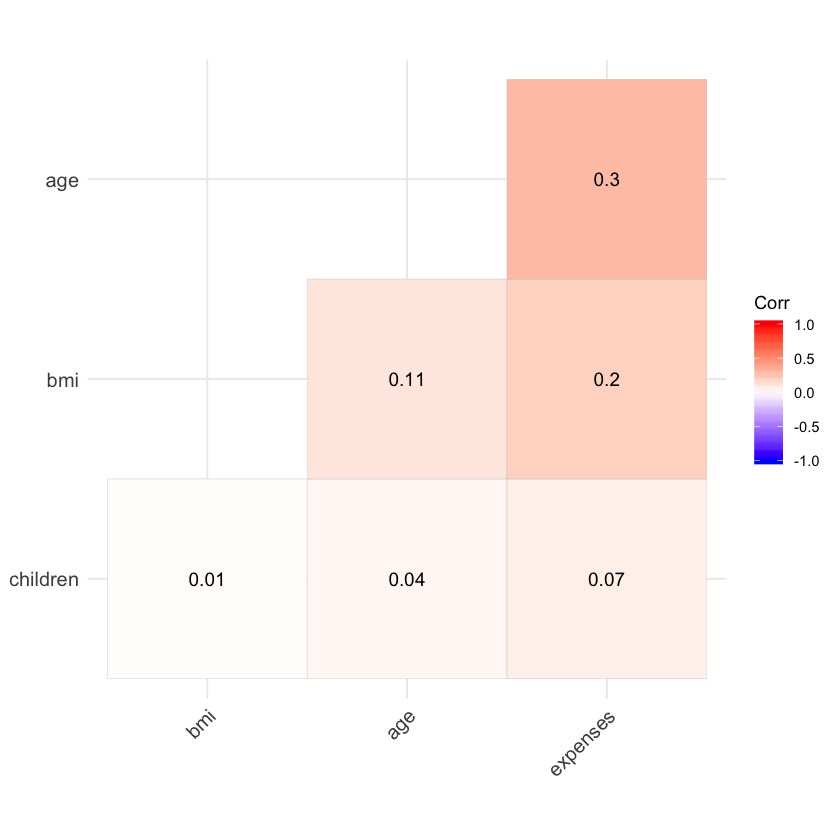

In [47]:
ggcorrplot(mat_corr, hc.order = TRUE, type = "lower",
   lab = TRUE)

Aucune des corrélations de la matrice n'est très forte, mais il existe quelques associations notables. Par exemple, l'âge et le bmi semblent avoir une faible corrélation positive, ce qui signifie que plus une personne vieillit, plus sa masse corporelle a tendance à augmenter. Il existe également des corrélations positives entre l'âge et les dépenses, bmi et les dépenses, et les enfants et les dépenses. Ces associations impliquent qu'avec l'augmentation de l'âge, de la masse corporelle et du nombre d'enfants, le coût attendu des dépenses de santé est plus élevé.  Nous essaierons de faire ressortir ces relations plus clairement lorsque nous construirons notre modèle de régression final.

## Visualisation des relations entre les caractéristiques 

Il peut également être utile de visualiser les relations entre les caractéristiques numériques à l'aide de nuages de points. Bien que nous puissions créer un nuage de points pour chaque relation possible, le faire pour un grand nombre de caractéristiques devient rapidement fastidieux.


In [52]:
# install.packages("psych")

In [54]:
library(psych)

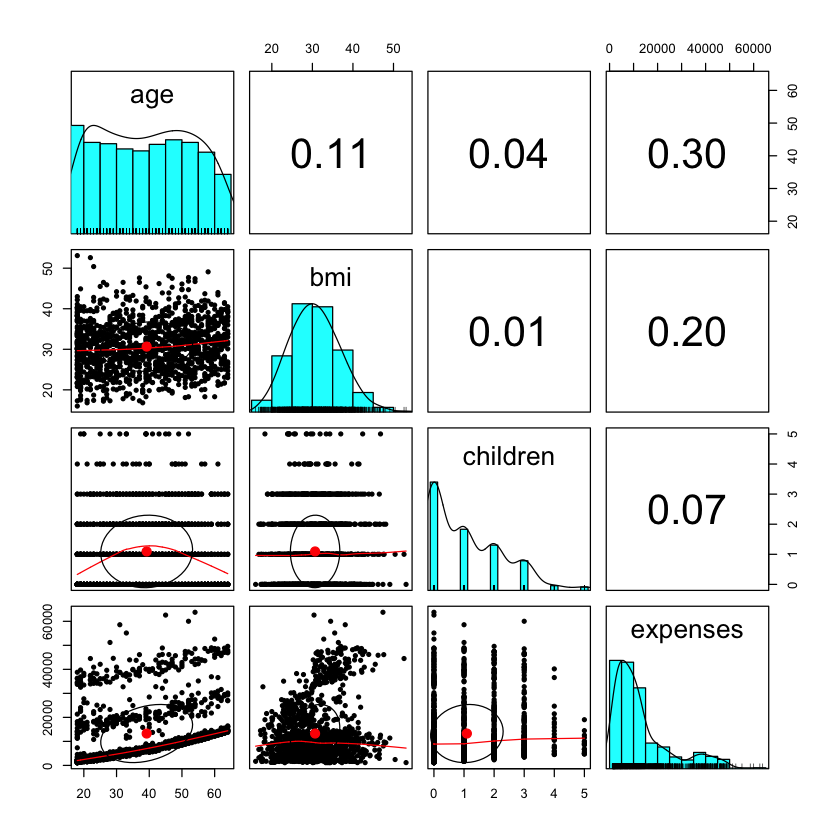

In [57]:
pairs.panels(insurance[c("age", "bmi", "children", "expenses")])

Remarquez-vous des tendances dans ces graphiques ? Bien que certains ressemblent à des nuages de points aléatoires, quelques-uns semblent présenter des tendances. La relation entre l'âge et les dépenses présente plusieurs lignes relativement droites, tandis que le tracé de bmi par rapport aux dépenses présente deux groupes de points distincts. Il est difficile de détecter des tendances dans les autres graphiques.

Les nuages de points au-dessus de la diagonale sont remplacés par une matrice de corrélation. La diagonale contient maintenant des histogrammes qui dépeignent
la distribution des valeurs pour chaque caractéristique. Enfin, les nuages de points situés sous la diagonale sont présentés avec des informations visuelles supplémentaires.

L'objet de forme ovale sur chaque nuage de points est une ellipse de corrélation. Elle permet de visualiser la force de la corrélation. Plus l'ellipse est étirée, plus la corrélation est forte. Un ovale presque parfaitement rond, comme pour bmi et les enfants, indique une corrélation très faible (dans ce cas, 0,01).

L'ellipse pour l'âge et les dépenses est beaucoup plus étirée, reflétant sa plus forte corrélation (0,30). Le point au centre de l'ellipse est un point reflétant les moyennes des variables de l'axe des x et de l'axe des y.

La courbe dessinée sur le nuage de points est appelée courbe de `loess`. Elle indique la relation générale entre les variables de l'axe des x et de l'axe des y. Elle est mieux comprise à l'aide d'un exemple. La courbe pour l'âge et les enfants est un U inversé, qui culmine autour de l'âge moyen. Cela signifie que les personnes les plus âgées et les plus jeunes de l'échantillon ont moins d'enfants à charge que les personnes d'âge moyen. Comme cette tendance n'est pas linéaire, ce résultat n'aurait pas pu être déduit des seules corrélations. D'autre part, la courbe de loess pour l'âge et le bmi est une ligne qui monte progressivement, ce qui implique que la masse corporelle augmente avec l'âge, mais nous l'avions déjà déduit de la matrice de corrélation.


## Ajustement du modèle

Pour ajuster un modèle de régression linéaire aux données avec R, la fonction lm() peut être utilisée. Elle fait partie du paquetage stats, qui doit être inclus et chargé par défaut dans votre installation de R. La syntaxe de la fonction lm() est la suivante :

In [55]:
ins_model <- lm(expenses ~ age + children + bmi + sex + smoker + region, data = insurance)

In [60]:
ins_model <- lm(expenses ~ ., data = insurance)

In [59]:
summary(ins_model)


Call:
lm(formula = expenses ~ ., data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11302.7  -2850.9   -979.6   1383.9  29981.7 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11941.6      987.8 -12.089  < 2e-16 ***
age                256.8       11.9  21.586  < 2e-16 ***
sexmale           -131.3      332.9  -0.395 0.693255    
bmi                339.3       28.6  11.864  < 2e-16 ***
children           475.7      137.8   3.452 0.000574 ***
smokeryes        23847.5      413.1  57.723  < 2e-16 ***
regionnorthwest   -352.8      476.3  -0.741 0.458976    
regionsoutheast  -1035.6      478.7  -2.163 0.030685 *  
regionsouthwest   -959.3      477.9  -2.007 0.044921 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6062 on 1329 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7494 
F-statistic: 500.9 on 8 and 1329 DF,  p-value: < 2.2e-16


La compréhension des coefficients de régression $\beta$ est assez simple. L'ordonnée à l'intercept est la valeur prédite des dépenses lorsque les variables indépendantes sont égales à zéro. Cependant, dans de nombreux cas, l'ordonnée à l'origine a peu de valeur explicative en soi, car il est souvent impossible d'avoir des valeurs nulles pour toutes les caractéristiques. C'est le cas ici, où aucune personne ne peut exister avec un âge et un IMC nuls, et par conséquent, l'ordonnée à l'origine n'a aucune interprétation dans le monde réel. C'est pourquoi, dans la pratique, l'ordonnée à l'origine est souvent ignorée.

Les coefficients bêta indiquent l'augmentation estimée des dépenses pour une augmentation d'une unité de chaque caractéristique, en supposant que les autres valeurs restent constantes. Par exemple, pour chaque année d'âge supplémentaire, on s'attend à une augmentation moyenne des frais médicaux de 256,80, en supposant quetoutes les autres valeurs restent constantes.

De même, chaque enfant supplémentaire entraîne en moyenne 475,70 de frais médicaux supplémentaires chaque année, et chaque unité d'augmentation de l'IMC est associée à une augmentation moyenne de 339,30 des frais médicaux annuels, toutes choses égales par ailleurs.

Vous remarquerez peut-être que, bien que nous n'ayons spécifié que six caractéristiques dans notre formule de modèle, huit coefficients sont indiqués en plus de l'ordonnée à l'origine. Cela s'est produit parce que la fonction lm() applique automatiquement un codage fictif à chacune des variables de type facteur incluses dans le modèle.

Le codage fictif permet de traiter une caractéristique nominale comme numérique en créant une variable binaire pour chaque catégorie de la caractéristique. La variable fictive prend la valeur 1 si l'observation entre dans la dans la catégorie spécifiée ou 0 sinon. 

Par exemple, la caractéristique sexe a deux catégories : homme et femme. Elle sera divisée en deux variables binaires, que R nomme sexmale et sexfemale. Pour les observations où sexe = masculin, alors sexmale = 1 et sexfemale = 0 ; inversement, si sexe = féminin, alors sexmale = 0 et sexfemale = 1. 

Le même codage s'applique aux variables comportant trois catégories ou plus. Par exemple, R a divisé la caractéristique région, qui comporte quatre catégories, en quatre variables fictives : regionnorthwest, regionsoutheast, regionsouthwest et regionnortheast.

Lorsque l'on ajoute une variable fictive à un modèle de régression, une catégorie est toujours laissée de côté pour servir de catégorie de référence. Les estimations sont alors interprétées par rapport à la référence. 

Dans notre modèle, R a automatiquement écarté les variables sexfemale, smokerno, et regionnortheast, faisant des femmes non-fumeuses de la région nord-est le groupe de référence. Ainsi, les hommes ont 131,40\\$ de moins de frais médicaux par an que les femmes et les fumeurs coûtent en moyenne 23 847,50\\$ de plus que les non-fumeurs par an. Le coefficient pour chacune des trois régions du modèle est négatif, ce qui implique que le groupe de référence, la région nord-est, tend à avoir les dépenses moyennes les plus élevées.

Les résultats du modèle de régression linéaire sont logiques : la vieillesse, le tabagisme et l'obésité ont tendance à être liés à des problèmes de sané, tandis que l'augmentation du nombre de membres de la famille à charge peut entraîner une augmentation des visites chez le médecin et des soins préventifs tels que les vaccins et les examens physiques annuels. Cependant, nous n'avons actuellement aucune idée de la façon dont le modèle s'adapte aux données.

## Évaluation de la performance du modèle
Les estimations des paramètres que nous avons obtenues en tapant ins_model nous renseignent sur la façon dont les variables indépendantes sont liées à la variable dépendante, mais elles ne nous disent rien sur la façon dont le modèle s'ajuste aux données. Pour évaluer la performance du modèle, nous pouvons utiliser la commande `summary()` sur le modèle stocké :


In [61]:
summary(ins_model)


Call:
lm(formula = expenses ~ ., data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11302.7  -2850.9   -979.6   1383.9  29981.7 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11941.6      987.8 -12.089  < 2e-16 ***
age                256.8       11.9  21.586  < 2e-16 ***
sexmale           -131.3      332.9  -0.395 0.693255    
bmi                339.3       28.6  11.864  < 2e-16 ***
children           475.7      137.8   3.452 0.000574 ***
smokeryes        23847.5      413.1  57.723  < 2e-16 ***
regionnorthwest   -352.8      476.3  -0.741 0.458976    
regionsoutheast  -1035.6      478.7  -2.163 0.030685 *  
regionsouthwest   -959.3      477.9  -2.007 0.044921 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6062 on 1329 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7494 
F-statistic: 500.9 on 8 and 1329 DF,  p-value: < 2.2e-16


### Les résidus

La section Résidus fournit des statistiques sommaires pour les erreurs dans nos prédictions, dont certaines sont apparemment assez importantes. Puisqu'un résidu
est égal à la valeur réelle moins la valeur prédite, l'erreur maximale de 29981,7 suggère que le modèle a sous-estimé les dépenses de près de 30 000 \\$ pour au moins une observation. D'autre part, 50 % des erreurs se situent à l'intérieur des valeurs 1Q et 3Q (le premier et le troisième quartile), de sorte que la majorité des prédictions se situaient entre 2 850,90 \\$ au-dessus de la valeur réelle et 1 383,90 \\$ au-dessous de la valeur réelle.

### p-value
Pour chaque coefficient de régression estimé, la valeur `p`, appelée `Pr(>|t|)`, fournit une estimation de la probabilité que le vrai coefficient soit nul compte tenu de la valeur de l'estimation. De petites valeurs `p` suggèrent qu'il est très peu probable que le coefficient réel soit nul, ce qui signifie qu'il est extrêmement peu probable que la caractéristique n'ait aucune relation avec la variable dépendante. Notez que certaines des valeurs p comportent des étoiles $\text{(***)}$, qui correspondent aux notes de bas de page qui précisent le niveau de signification atteint par l'estimation. Ce niveau est un seuil, choisi avant la construction du modèle, qui sera utilisé pour indiquer les résultats "réels", par opposition à ceux dus au seul hasard ; les valeurs p inférieures au niveau de signification sont considérées comme statistiquement significatives. Si le modèle comportait peu de termes de ce type, cela pourrait être une source d'inquiétude, car cela indiquerait que les caractéristiques utilisées ne sont pas très prédictives du résultat. Ici, notre modèle comporte plusieurs variables hautement significatives, et elles semblent être liées au résultat de manière logique.

### R-carré
La valeur du R-carré (également appelée coefficient de détermination) fournit une mesure de l'efficacité avec laquelle notre modèle dans son ensemble explique les valeurs de la variable dépendante. Il est similaire au coefficient de corrélation en ce sens que
plus la valeur est proche de 1,0, plus le modèle explique parfaitement les données. Comme la valeur du R-carré est de 0,7494, nous savons que le modèle explique près de 75 % de la variation de la variable dépendante. Étant donné que les modèles comportant plus de caractéristiques expliquent toujours plus de variation, la valeur R-carré ajustée corrige le R-carré en pénalisant les modèles comportant un grand nombre de variables indépendantes. Elle est utile pour comparer les performances de modèles comportant un nombre différent de variables explicatives.

## Amélioration des performances du modèle
Comme mentionné précédemment, une différence essentielle entre la modélisation par régression et d'autres approches comme l'apprentissage statistique est que la régression laisse généralement la sélection des caractéristiques et la spécification du modèle à l'utilisateur. Par conséquent, si nous avons des connaissances sur la façon dont une caractéristique est liée au résultat, nous pouvons utiliser cette information pour informer la spécification du modèle et potentiellement améliorer la performance du modèle.

### Ajout de relations non linéaires
Dans la régression linéaire, la relation entre une variable indépendante et la variable dépendante est supposée être linéaire, mais cela n'est pas nécessairement vrai. Par exemple, l'effet de l'âge sur les dépenses médicales peut ne pas être constant pour toutes les valeurs d'âge ; le traitement peut devenir disproportionnellement cher pour les populations les plus âgées.

Si vous vous rappelez, une équation de régression typique suit une forme similaire à celle-ci :

$$
y=\alpha+\beta_{1} x
$$

Pour tenir compte d'une relation non linéaire, nous pouvons ajouter un terme d'ordre supérieur à l'équation de régression, en traitant le modèle comme un polynôme. En effet, nous modéliserons une relation comme celle-ci :

$$
y=\alpha+\beta_{1} x+\beta_{2} x^{2}
$$

La différence entre ces deux modèles est qu'un bêta supplémentaire sera estimé, qui est destiné à capturer l'effet du terme x2. Cela permet de mesurer l'impact de l'âge comme une fonction de l'âge au carré.

Pour ajouter l'âge non linéaire au modèle, nous devons simplement créer une nouvelle variable :


In [62]:
insurance$age2 <- insurance$age**2

In [63]:
head(insurance)

age sex    bmi  children smoker region    expenses age2
1 19  female 27.9 0        yes    southwest 16884.92  361
2 18  male   33.8 1        no     southeast  1725.55  324
3 28  male   33.0 3        no     southeast  4449.46  784
4 33  male   22.7 0        no     northwest 21984.47 1089
5 32  male   28.9 0        no     northwest  3866.86 1024
6 31  female 25.7 0        no     southeast  3756.62  961

Ensuite, lorsque nous produirons notre modèle amélioré, nous ajouterons l'âge et l'âge2 à la formule `lm()` en utilisant la forme `expenses ~ age + age2`. Cela permettra au modèle de séparer l'impact linéaire et non linéaire de l'âge sur les dépenses médicales.


### Convertir une variable numérique en un indicateur binaire
Supposons que nous ayons l'intuition que l'effet d'une caractéristique n'est pas cumulatif, mais qu'elle n'a un effet qu'après avoir atteint un seuil spécifique. Par exemple, l'IMC peut n'avoir aucun impact sur les dépenses médicales des personnes ayant un poids normal, mais il peut être fortement lié à des coûts plus élevés pour les personnes obèses (c'est-à-dire un IMC de 30 ou plus).
30 ou plus).

Nous pouvons modéliser cette relation en créant une variable binaire indicatrice d'obésité qui vaut 1 si l'IMC est d'au moins 30 et 0 s'il est inférieur à 30. Le bêta estimé pour cette caractéristique binaire indiquerait alors l'impact net moyen sur les dépenses médicales des individus ayant un IMC de 30 ou plus, par rapport à ceux ayant un IMC inférieur à 30.

Pour créer la caractéristique, nous pouvons utiliser la fonction `ifelse()`qui, pour chaque élément d'un vecteur, teste une condition spécifiée et renvoie une valeur selon que la condition est vraie ou fausse. Pour un IMC supérieur ou égal à 30, nous retournerons 1, sinon nous retournerons 0 :

In [64]:
insurance$bmi30 <- ifelse(insurance$bmi >= 30, 1, 0)

Nous pouvons alors inclure la variable bmi30 dans notre modèle amélioré, soit en remplacement de la variable `bmi` initiale, soit en plus de celle-ci, selon que nous pensons ou non que l'effet de l'obésité se produit en plus d'un effet linéaire distinct de l'IMC. Sans raison valable de faire autrement, nous inclurons les deux dans notre modèle final.

### Spécification du modèle - ajout d'effets d'interaction
Jusqu'à présent, nous n'avons considéré que la contribution individuelle de chaque caractéristique au résultat. Que se passe-t-il si certaines caractéristiques ont un impact combiné sur la variable dépendante ? Par exemple, le tabagisme et l'obésité peuvent avoir des effets néfastes séparément, mais il est raisonnable de supposer que leur effet combiné peut être pire que la somme de chacun d'entre eux.

Lorsque deux caractéristiques ont un effet combiné, on parle d'interaction. Si
nous soupçonnons que deux variables interagissent, nous pouvons tester cette hypothèse en ajoutant leur interaction au modèle. Les effets d'interaction sont spécifiés à l'aide de la syntaxe de la formule R. Pour faire interagir l'indicateur d'obésité (bmi30) avec l'indicateur de tabagisme (smoker), nous écririons une formule de la forme `expenses ~ bmi30*smoker.`

L'opérateur * est un raccourci qui indique à R de modéliser les `expenses ~ bmi30 + smokeryes + bmi30:smokeryes`. L'opérateur deux points (:) dans la forme développée indique que `bmi30:smokeryes` est l'interaction entre les deux variables. Notez que la forme développée inclut automatiquement les variables individuelles bmi30 et smokeryes ainsi que leur interaction.

### Tout mettre ensemble - un modèle de régression amélioré

En nous basant sur une certaine connaissance de la manière dont les coûts médicaux peuvent être liés aux caractéristiques des patients, nous avons développé ce que nous pensons être une formule de régression plus précise. Pour résumer les améliorations, nous avons :
- Ajouté un terme non linéaire pour l'âge
- Créé un indicateur pour l'obésité
- spécifié une interaction entre l'obésité et le tabagisme.
Nous entraînerons le modèle à l'aide de la fonction `lm()` comme précédemment, mais cette fois, nous ajouterons les variables nouvellement construites et le terme d'interaction :

In [66]:
ins_model2 <- lm(expenses ~ age + age2 + children + 
                 bmi + sex + bmi30*smoker + region, data = insurance)

In [67]:
summary(ins_model2)


Call:
lm(formula = expenses ~ age + age2 + children + bmi + sex + bmi30 * 
    smoker + region, data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-17297.1  -1656.0  -1262.7   -727.8  24161.6 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       139.0053  1363.1359   0.102 0.918792    
age               -32.6181    59.8250  -0.545 0.585690    
age2                3.7307     0.7463   4.999 6.54e-07 ***
children          678.6017   105.8855   6.409 2.03e-10 ***
bmi               119.7715    34.2796   3.494 0.000492 ***
sexmale          -496.7690   244.3713  -2.033 0.042267 *  
bmi30            -997.9355   422.9607  -2.359 0.018449 *  
smokeryes       13404.5952   439.9591  30.468  < 2e-16 ***
regionnorthwest  -279.1661   349.2826  -0.799 0.424285    
regionsoutheast  -828.0345   351.6484  -2.355 0.018682 *  
regionsouthwest -1222.1619   350.5314  -3.487 0.000505 ***
bmi30:smokeryes 19810.1534   604.6769  32.762  < 2e-16 ***

Les statistiques d'ajustement du modèle permettent de déterminer si nos modifications ont amélioré les performances du modèle de régression. Par rapport à notre premier modèle, la valeur du R-carré s'est améliorée, passant de 0,75 à environ 0,87.

De même, la valeur R-carré ajustée, qui tient compte du fait que le modèle a gagné en complexité, est passée de 0,75 à 0,87. Notre modèle explique désormais 87 % de la variation des coûts des traitements médicaux. De plus, nos théories sur la forme fonctionnelle du modèle semblent être validées. Le terme d'ordre supérieur âge2 est statistiquement significatif, tout comme l'indicateur d'obésité, bmi30. L'interaction entre l'obésité et le tabagisme suggère un effet massif ; en plus de l'augmentation des coûts de plus de 13 404 \\$ pour le tabagisme seul, les fumeurs obèses dépensent 19 810 \\$ de plus par an. Cela pourrait suggérer que le tabagisme exacerbe les maladies associées à l'obésité.

## Prédictions avec un modèle de régression

Après avoir examiné les coefficients de régression estimés et les statistiques d'ajustement, nous pouvons également utiliser le modèle pour prédire les dépenses des futures personnes inscrites au régime d'assurance maladie. Pour illustrer le processus de prédiction, appliquons d'abord le modèle aux données d'apprentissage d'origine à l'aide de la fonction `predict`. aux données d'origine à l'aide de la fonction predict() comme suit :


In [68]:
insurance$pred <- predict(ins_model2, insurance)

Cela enregistre les prédictions comme un nouveau vecteur nommé pred dans le cadre de données d'assurance. Nous pouvons alors calculer la corrélation entre les coûts d'assurance prédits et réels :

In [69]:
cor(insurance$pred, insurance$expenses)

[1] 0.9307999

La corrélation de 0,93 suggère une relation linéaire très forte entre les valeurs prédites et les valeurs réelles. Il s'agit d'un bon signe, qui suggère que le modèle est très précis ! Il peut également être utile d'examiner ce résultat sous forme de nuage de points. Les commandes R suivantes permettent de tracer la relation, puis d'ajouter une droite pointillée avec un intercept égal à zéro et une pente égale à un. Les paramètres col, lwd et lty affectent la couleur, la largeur et le type de ligne, respectivement :


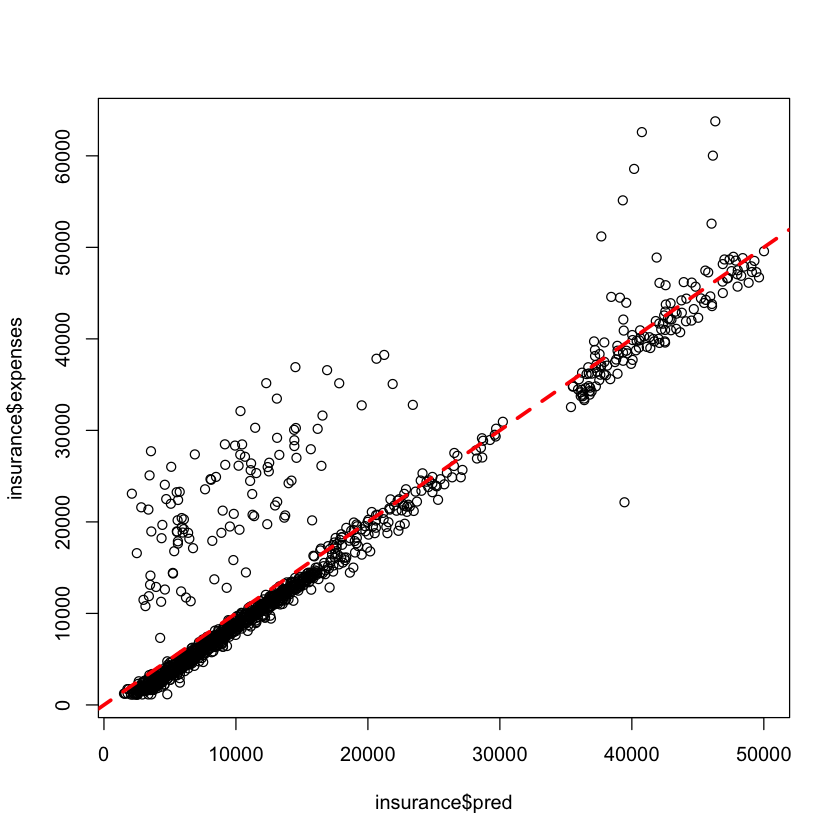

In [71]:
plot(insurance$pred, insurance$expenses)
abline(a = 0, b = 1, col = "red", lwd = 3, lty = 2)


Les points hors diagonale qui se situent au-dessus de la ligne correspondent aux cas où les dépenses réelles étaient supérieures aux prédictions, tandis que les cas qui se situent en dessous de la ligne sont ceux qui sont inférieurs aux prédictions. Nous pouvons voir ici qu'un petit nombre de patients ayant des dépenses médicales beaucoup plus importantes que prévu est équilibré par un plus grand nombre de patients ayant des dépenses légèrement inférieures à celles prédites.

Supposons que nous voulons estimer les frais d'assurance d'un homme de 30 ans, en surpoids, non-fumeur et père de deux enfants dans le Nord-Est:

In [75]:
predict(ins_model,data.frame(age = 30, age2 = 30^2, children = 2,bmi = 30, sex = "male", bmi30 = 1, smoker = "no", region = "northeast"))


1 
6762.334

In [73]:
predict(ins_model2,data.frame(age = 30, age2 = 30^2, children = 2,bmi = 30, sex = "male", bmi30 = 1, smoker = "no", region = "northeast"))

1 
5973.774

En utilisant cette valeur, la compagnie d'assurance pourrait devoir fixer ses prix à environ 6 000 \\$ par an, ou 500 \\$ par mois, afin d'atteindre le seuil de rentabilité pour ce groupe démographique. Pour comparer le tarif d'une femme similaire, utilisez la fonction predict() de la même manière :

In [76]:
predict(ins_model2,data.frame(age = 30, age2 = 30^2, children = 2,bmi = 30, sex = "female", bmi30 = 1, smoker = "no", region = "northeast"))

1 
6470.543

Notez que la différence entre ces deux valeurs, 5 973,774 - 6 470,543 = -496,769, est la même que le coefficient estimé du modèle de régression pour sexmale. En moyenne, on estime que les hommes ont environ 496 \\$ de moins en dépenses pour le régime par année, toutes choses étant égales par ailleurs.
